## ChemBERTa
ChemBERTa: A collection of BERT-like models applied to chemical SMILES data for drug design, chemical modelling, and property prediction. To be presented at [Baylearn](https://baylearn2020.splashthat.com/) and the [Royal Society of Chemistry's Chemical Science Symposium](https://www.rsc.org/events/detail/42791/chemical-science-symposium-2020-how-can-machine-learning-and-autonomy-accelerate-chemistry).

[Tutorial](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/22_Transfer_Learning_With_HuggingFace_tox21.ipynb) <br />
[Arxiv Paper](https://arxiv.org/abs/2010.09885) <br />
[Poster](https://chemsci20.ipostersessions.com/Default.aspx?s=99-39-E6-B6-B0-0E-E1-D8-FB-66-1A-44-DC-A3-43-BA) <br />
[Abstract](https://t.co/dkA5rMvYrE?amp=1) <br />
[BibTex](https://scholar.googleusercontent.com/scholar.bib?q=info:FzDMp7nctLUJ:scholar.google.com/&output=citation&scisdr=CgWWnePlEM-dmmZXtDE:AAGBfm0AAAAAX5RSrDGmJTVdPMFfzRSs5UY9lD4iRvvd&scisig=AAGBfm0AAAAAX5RSrGbFzGg583aNAYQw1Lap1K79xkEm&scisf=4&ct=citation&cd=-1&hl=en)

Right now the notebooks are all for the RoBERTa model (a variant of BERT) trained on the task of masked-language modelling (MLM). Training was done over 10 epochs until loss converged to around 0.26 on the ZINC 250k dataset. The model weights for ChemBERTA pre-trained on various datasets (ZINC 100k, ZINC 250k, PubChem 100k, PubChem 250k, PubChem 1M, PubChem 10M) are available using [HuggingFace](https://huggingface.co/seyonec). We expect to continue to release larger models pre-trained on even larger subsets of ZINC, CHEMBL, and PubChem in the near future. 

Credit: https://github.com/seyonechithrananda/bert-loves-chemistry

In [ ]:
# Install dependencies / requirements
!pip install dgl rdkit-pypi==2021.3.1.5 dgllife

### Atom Weight Visualization

In [5]:
import copy
import dgl
import matplotlib
import matplotlib.cm as cm
import torch

from functools import partial
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from dgllife.data import PubChemBioAssayAromaticity
from dgllife.data import Tox21
from dgllife.model import load_pretrained
from dgllife.utils.featurizers import BaseAtomFeaturizer, ConcatFeaturizer, atom_type_one_hot, \
    atom_degree_one_hot, atom_formal_charge, atom_num_radical_electrons, \
    atom_hybridization_one_hot, atom_total_num_H_one_hot, BaseBondFeaturizer

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


Prepare the model, dataset and the features.

In [6]:
# Prepare featurization functions for atoms and bonds
def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]

atom_featurizer = BaseAtomFeaturizer(featurizer_funcs={'hv': ConcatFeaturizer([
                                      partial(atom_type_one_hot, 
                                              allowable_set=['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 
                                                             'As', 'Se', 'Br', 'Te', 'I', 'At'],
                                              encode_unknown=True),
                                      partial(atom_degree_one_hot, allowable_set=list(range(6))),
                                      atom_formal_charge, atom_num_radical_electrons,
                                      partial(atom_hybridization_one_hot, encode_unknown=True),
                                      lambda atom: [0], # A placeholder for aromatic information,
                                      atom_total_num_H_one_hot, chirality])})
bond_featurizer = BaseBondFeaturizer({'he': lambda bond: [0 for _ in range(10)]})

#dataset = PubChemBioAssayAromaticity(node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer)
dataset = Tox21(node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer)
model = load_pretrained('AttentiveFP_Aromaticity').eval()

Processing dgl graphs from scratch...
Processing molecule 1000/7831
Processing molecule 2000/7831
Processing molecule 3000/7831
Processing molecule 4000/7831
Processing molecule 5000/7831
Processing molecule 6000/7831
Processing molecule 7000/7831
Pretrained model loaded


In [7]:
def draw(mol_id, dataset, timestep):
    """Visualize the learned atom weights in readout.
    
    Parameters
    ----------
    mol_id : int
        Index for the molecule to visualize in the dataset.
    dataset
    timestep : int
        As the model has multiple rounds of readout, an additional
        index is used to specify the round for the weights.
    """
    # Get the weights from the model.
    smiles, g, _, _ = dataset[mol_id]
    print(smiles)
    g = dgl.batch([g])
    atom_feats, bond_feats = g.ndata.pop('hv'), g.edata.pop('he')
    _, atom_weights = model(g, atom_feats, bond_feats, get_node_weight=True)
    
    assert timestep < len(atom_weights), 'Unexpected id for the readout round.'
    atom_weights = atom_weights[timestep]
    min_value = torch.min(atom_weights)
    max_value = torch.max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)
    
    # Conver the weights to atom colors
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
    cmap = cm.get_cmap('Oranges')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(g.number_of_nodes())}

    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(g.number_of_nodes()),highlightBonds=[],
    highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    display(SVG(svg))

CCOc1ccc(N=Nc2ccc(N)cc2N)cc1


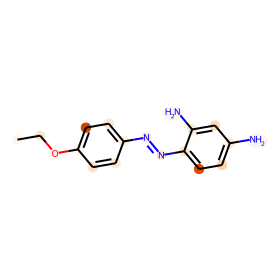

In [8]:
draw(978, dataset, 0)

### DeepChem Dev

In [ ]:
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [10]:
import tensorflow as tf
print("tf.__version__: %s" % str(tf.__version__))
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tf.__version__: 2.5.0
Found GPU at: /device:GPU:0


In [11]:
!git clone https://github.com/deepchem/deepchem.git

Cloning into 'deepchem'...
remote: Enumerating objects: 47201, done.
remote: Counting objects: 100% (4046/4046), done.
remote: Compressing objects: 100% (1106/1106), done.
remote: Total 47201 (delta 3202), reused 3684 (delta 2913), pack-reused 43155
Receiving objects: 100% (47201/47201), 495.14 MiB | 27.64 MiB/s, done.
Resolving deltas: 100% (35513/35513), done.


In [12]:
%cd deepchem/
!ls

/content/bert-loves-chemistry/deepchem
CODE_OF_CONDUCT.md  deepchem	    env.cpu.mac.yml  examples	requirements
contrib		    docker	    env.cpu.yml      LICENSE	scripts
CONTRIBUTING.md     docs	    env.gpu.yml      notes	setup.cfg
datasets	    env.common.yml  env.test.yml     README.md	setup.py


In [ ]:
!python setup.py install

In [14]:
import deepchem as dc

In [15]:
delaney_tasks, delaney_datasets, transformers = dc.molnet.load_delaney(
    featurizer='GraphConv', split='index')                       
train_dataset, valid_dataset, test_dataset = delaney_datasets

'split' is deprecated.  Use 'splitter' instead.


In [17]:
import numpy as np

# Set up to Fit models                                                     
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean) 

n_atom_feat = 75                                                 
batch_size = 64

max_atoms_train = max([mol.get_num_atoms() for mol in train_dataset.X]) 
max_atoms_valid = max([mol.get_num_atoms() for mol in valid_dataset.X])
max_atoms_test = max([mol.get_num_atoms() for mol in test_dataset.X]) 
max_atoms = max([max_atoms_train, max_atoms_valid, max_atoms_test])   

reshard_size = 512
transformer = dc.trans.DAGTransformer(max_atoms=max_atoms)       
train_dataset.reshard(reshard_size)
train_dataset = transformer.transform(train_dataset)             
valid_dataset.reshard(reshard_size)                              
valid_dataset = transformer.transform(valid_dataset)

In [18]:
import logging
logging.basicConfig(level=logging.INFO)

model = dc.models.DAGModel(
    len(delaney_tasks),
    max_atoms=max_atoms,
    n_atom_feat=n_atom_feat,
    batch_size=batch_size,
    learning_rate=1e-3,
    use_queue=False,
    mode='regression')

# Fit trained model
model.fit(train_dataset, nb_epoch=10)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
INFO:deepchem.models.keras_model:Ending global_step 100: Average loss 0.306781
INFO:deepchem.models.keras_model:Ending global_step 150: Average loss 0.0692115
INFO:deepchem.models.keras_model:TIMING: model fitting took 43.667 s


0.06921153545379638

In [19]:
print("Evaluating model")                                        
train_scores = model.evaluate(train_dataset, [metric], transformers)      
valid_scores = model.evaluate(valid_dataset, [metric], transformers)    

print("Train scores")                                            
print(train_scores)

print("Validation scores")                                       
print(valid_scores)

Evaluating model


INFO:deepchem.metrics.metric:computed_metrics: [0.9527123248804458]
INFO:deepchem.metrics.metric:computed_metrics: [0.8512181676442159]


Train scores
{'mean-pearson_r2_score': 0.9527123248804458}
Validation scores
{'mean-pearson_r2_score': 0.8512181676442159}


In [20]:
# Fit trained model
model.fit(train_dataset, nb_epoch=100)

INFO:deepchem.models.keras_model:Ending global_step 200: Average loss 0.0418595
INFO:deepchem.models.keras_model:Ending global_step 300: Average loss 0.0255916
INFO:deepchem.models.keras_model:Ending global_step 400: Average loss 0.0204049
INFO:deepchem.models.keras_model:Ending global_step 500: Average loss 0.0111373
INFO:deepchem.models.keras_model:Ending global_step 600: Average loss 0.00687582
INFO:deepchem.models.keras_model:Ending global_step 700: Average loss 0.00924469
INFO:deepchem.models.keras_model:Ending global_step 800: Average loss 0.00682331
INFO:deepchem.models.keras_model:Ending global_step 900: Average loss 0.00657962
INFO:deepchem.models.keras_model:Ending global_step 1000: Average loss 0.00636789
INFO:deepchem.models.keras_model:Ending global_step 1100: Average loss 0.00343537
INFO:deepchem.models.keras_model:Ending global_step 1200: Average loss 0.00449624
INFO:deepchem.models.keras_model:Ending global_step 1300: Average loss 0.00399062
INFO:deepchem.models.keras_m

0.011928639411926269

In [21]:
print("Evaluating model")                                        
train_scores = model.evaluate(train_dataset, [metric], transformers)      
valid_scores = model.evaluate(valid_dataset, [metric], transformers)    

print("Train scores")                                            
print(train_scores)

print("Validation scores")                                       
print(valid_scores)

Evaluating model


INFO:deepchem.metrics.metric:computed_metrics: [0.9902864419377254]
INFO:deepchem.metrics.metric:computed_metrics: [0.8863287343093835]


Train scores
{'mean-pearson_r2_score': 0.9902864419377254}
Validation scores
{'mean-pearson_r2_score': 0.8863287343093835}


In [22]:
# Fit trained model
model.fit(train_dataset, nb_epoch=500)

INFO:deepchem.models.keras_model:Ending global_step 1700: Average loss 0.00935127
INFO:deepchem.models.keras_model:Ending global_step 1800: Average loss 0.00634114
INFO:deepchem.models.keras_model:Ending global_step 1900: Average loss 0.00860736
INFO:deepchem.models.keras_model:Ending global_step 2000: Average loss 0.00240924
INFO:deepchem.models.keras_model:Ending global_step 2100: Average loss 0.0010416
INFO:deepchem.models.keras_model:Ending global_step 2200: Average loss 0.00244921
INFO:deepchem.models.keras_model:Ending global_step 2300: Average loss 0.0008837
INFO:deepchem.models.keras_model:Ending global_step 2400: Average loss 0.00144847
INFO:deepchem.models.keras_model:Ending global_step 2500: Average loss 0.00149354
INFO:deepchem.models.keras_model:Ending global_step 2600: Average loss 0.00254933
INFO:deepchem.models.keras_model:Ending global_step 2700: Average loss 0.00272081
INFO:deepchem.models.keras_model:Ending global_step 2800: Average loss 0.00440383
INFO:deepchem.mode

0.000637998878955841

In [23]:
print("Evaluating model")                                        
train_scores = model.evaluate(train_dataset, [metric], transformers)      
valid_scores = model.evaluate(valid_dataset, [metric], transformers)    

print("Train scores")                                            
print(train_scores)

print("Validation scores")                                       
print(valid_scores)

Evaluating model


INFO:deepchem.metrics.metric:computed_metrics: [0.9992201739864647]
INFO:deepchem.metrics.metric:computed_metrics: [0.87329398559047]


Train scores
{'mean-pearson_r2_score': 0.9992201739864647}
Validation scores
{'mean-pearson_r2_score': 0.87329398559047}


In [24]:
# Fit trained model
model.fit(train_dataset, nb_epoch=500)

INFO:deepchem.models.keras_model:Ending global_step 9200: Average loss 0.00111139
INFO:deepchem.models.keras_model:Ending global_step 9300: Average loss 0.00210983
INFO:deepchem.models.keras_model:Ending global_step 9400: Average loss 0.00199666
INFO:deepchem.models.keras_model:Ending global_step 9500: Average loss 0.00180869
INFO:deepchem.models.keras_model:Ending global_step 9600: Average loss 0.00205169
INFO:deepchem.models.keras_model:Ending global_step 9700: Average loss 0.00250762
INFO:deepchem.models.keras_model:Ending global_step 9800: Average loss 0.00343291
INFO:deepchem.models.keras_model:Ending global_step 9900: Average loss 0.00459251
INFO:deepchem.models.keras_model:Ending global_step 10000: Average loss 0.00418741
INFO:deepchem.models.keras_model:Ending global_step 10100: Average loss 0.00789442
INFO:deepchem.models.keras_model:Ending global_step 10200: Average loss 0.00457062
INFO:deepchem.models.keras_model:Ending global_step 10300: Average loss 0.00608389
INFO:deepche

0.00021761342883110048

In [25]:
print("Evaluating model")                                        
train_scores = model.evaluate(train_dataset, [metric], transformers)      
valid_scores = model.evaluate(valid_dataset, [metric], transformers)    

print("Train scores")                                            
print(train_scores)

print("Validation scores")                                       
print(valid_scores)

Evaluating model


INFO:deepchem.metrics.metric:computed_metrics: [0.9997926680372072]
INFO:deepchem.metrics.metric:computed_metrics: [0.8791714951982665]


Train scores
{'mean-pearson_r2_score': 0.9997926680372072}
Validation scores
{'mean-pearson_r2_score': 0.8791714951982665}


In [ ]:
# Fit trained model
model.fit(train_dataset, nb_epoch=2000)

In [ ]:
print("Evaluating model")                                        
train_scores = model.evaluate(train_dataset, [metric], transformers)      
valid_scores = model.evaluate(valid_dataset, [metric], transformers)    

print("Train scores")                                            
print(train_scores)

print("Validation scores")                                       
print(valid_scores)

In [ ]:
# Fit trained model
model.fit(train_dataset, nb_epoch=5000)

In [ ]:
print("Evaluating model")                                        
train_scores = model.evaluate(train_dataset, [metric], transformers)      
valid_scores = model.evaluate(valid_dataset, [metric], transformers)    

print("Train scores")                                            
print(train_scores)

print("Validation scores")                                       
print(valid_scores)

### Transfer Learning With ChemBERTa Transformers

Deep learning for chemistry and materials science remains a novel field with lots of potiential. However, the popularity of transfer learning based methods in areas such as NLP and computer vision have not yet been effectively developed in computational chemistry + machine learning. Using HuggingFace's suite of models and the ByteLevel tokenizer, we are able to train a large-transformer model, RoBERTa, on a large corpus of 10,000,000 SMILES strings from a commonly known benchmark chemistry dataset, PubChem.

Training RoBERTa over 10 epochs, the model achieves a pretty good loss of 0.198, and may likely continue to converge if trained for a larger number of epochs. The model can predict masked/corrupted tokens within a SMILES sequence/molecule, allowing for variants of a molecule within discoverable chemical space to be predicted.

By applying the representations of functional groups and atoms learned by the model, we can try to tackle problems of toxicity, solubility, drug-likeness, and synthesis accessibility on smaller datasets using the learned representations as features for graph convolution and attention models on the graph structure of molecules, as well as fine-tuning of BERT. Finally, we propose the use of attention visualization as a helpful tool for chemistry practitioners and students to quickly identify important substructures in various chemical properties.

Additionally, visualization of the attention mechanism have been seen through previous research as incredibly valuable towards chemical reaction classification. The applications of open-sourcing large-scale transformer models such as RoBERTa with HuggingFace may allow for the acceleration of these individual research directions.

A link to a repository which includes the training, uploading and evaluation notebook (with sample predictions on compounds such as Remdesivir) can be found here. All of the notebooks can be copied into a new Colab runtime for easy execution. This repository will be updated with new features, such as attention visualization, easier benchmarking infrastructure, and more. The work behind this tutorial has been published on Arxiv, and has been accepted for a highlight presentation at NeurIPS 2020's ML for Molecules Workshop, where we will highlight updates to this work.

For the sake of this tutorial, we'll be fine-tuning a pre-trained ChemBERTa on a small-scale molecule dataset, Clintox, to show the potiential and effectiveness of HuggingFace's NLP-based transfer learning applied to computational chemistry. Output for some cells are purposely cleared for readability, so do not worry if some output messages for your cells differ!

Installing DeepChem from source, alongside RDKit for molecule visualizations

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer

conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install --pre deepchem
import deepchem
from rdkit import Chem

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0   9336      0 --:--:-- --:--:-- --:--:--  9360


add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda

     |████████████████████████████████| 573kB 5.3MB/s 


We want to install NVIDIA's Apex tool, for the training pipeline used by simple-transformers and Weights and Biases.

In [ ]:
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install torch
!pip install -v --no-cache-dir /content/apex
!pip install transformers simpletransformers wandb
!cd ..

In [1]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


We're going to clone an auxillary repository, bert-loves-chemistry, which will enable us to use the MolNet dataloader for ChemBERTa, which automatically generates scaffold splits on any MoleculeNet dataset!

In [3]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 1219, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 1219 (delta 116), reused 109 (delta 87), pack-reused 989
Receiving objects: 100% (1219/1219), 48.54 MiB | 23.96 MiB/s, done.
Resolving deltas: 100% (766/766), done.


In [4]:
!nvidia-smi

Fri Jul  2 20:41:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now, to ensure our model demonstrates an understanding of chemical syntax and molecular structure, we'll be testing it on predicting a masked token/character within the SMILES molecule for benzene.

In [2]:
# Test if NVIDIA apex training tool works
from apex import amp

In [3]:
from transformers import AutoModelWithLMHead, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

model = AutoModelWithLMHead.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

2021-07-02 20:44:39.582154: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:847: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [4]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"

masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
  print(smi)

{'sequence': 'C1=CC=CC=C1', 'score': 0.9755934476852417, 'token': 33, 'token_str': '='}
{'sequence': 'C1=CC=CC#C1', 'score': 0.020923856645822525, 'token': 7, 'token_str': '#'}
{'sequence': 'C1=CC=CC1C1', 'score': 0.000765895121730864, 'token': 21, 'token_str': '1'}
{'sequence': 'C1=CC=CC2C1', 'score': 0.0004129770095460117, 'token': 22, 'token_str': '2'}
{'sequence': 'C1=CC=CC=[C1', 'score': 0.0002531906357035041, 'token': 352, 'token_str': '=['}


Here, we get some interesting results. The final branch, C1=CC=CC=C1, is a benzene ring. Since its a pretty common molecule, the model is easily able to predict the final double carbon bond with a score of 0.98. Let's get a list of the top 5 predictions (including the target, Remdesivir), and visualize them (with a highlighted focus on the beginning of the final benzene-like pattern).

In [7]:
import torch
import rdkit
import rdkit.Chem as Chem

from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image


def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset):    
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

In [8]:
sequence = f"C1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

input = tokenizer.encode(sequence, return_tensors="pt")
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
  smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
  print (smi)
  smi_mol = get_mol(smi)
  substructure_mol = get_mol(substructure)
  if smi_mol is None: # if the model's token prediction isn't chemically feasible
    continue
  Draw.MolToFile(smi_mol, smi+".png")
  matches = find_matches_one(smi_mol, substructure_mol)
  atomset = list(matches[0])
  img = get_image(smi_mol, atomset)
  img.format="PNG" 
  image_list.append(img)

C1=CC=CC=CC1
C1=CC=CC=CCC1
C1=CC=CC=CN1
C1=CC=CC=CCCC1
C1=CC=CC=CCO1


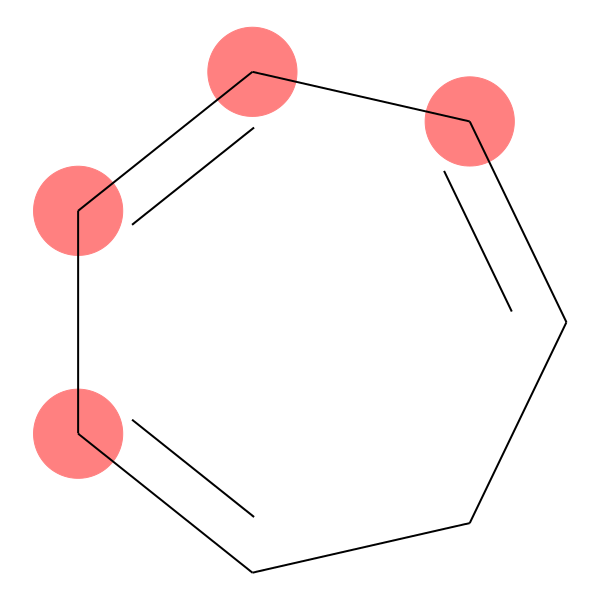

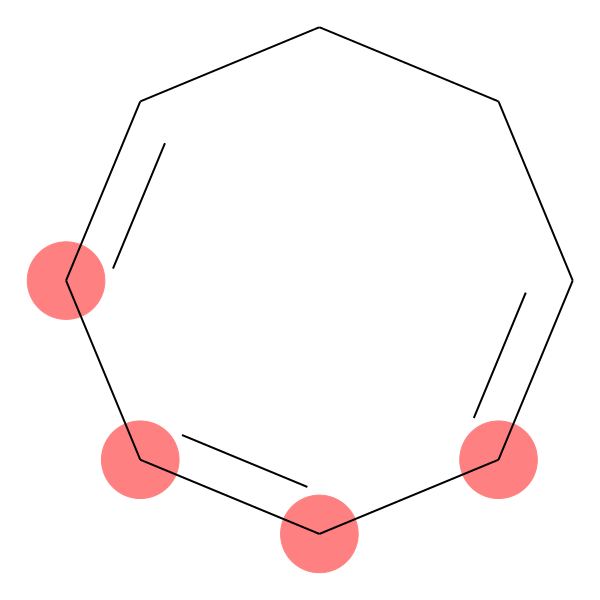

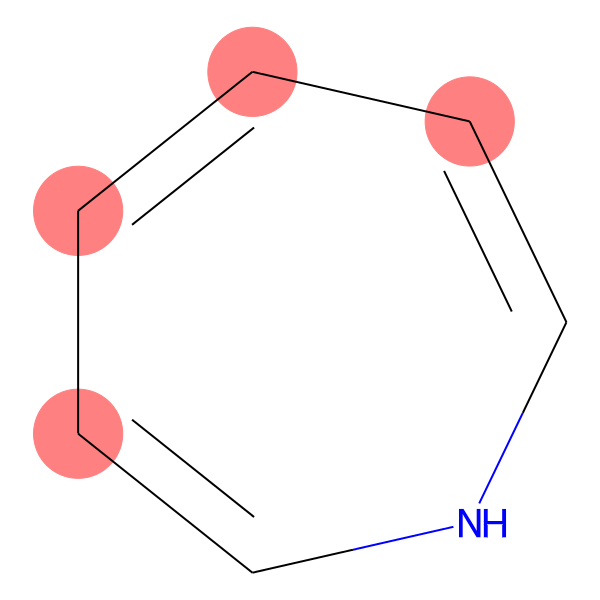

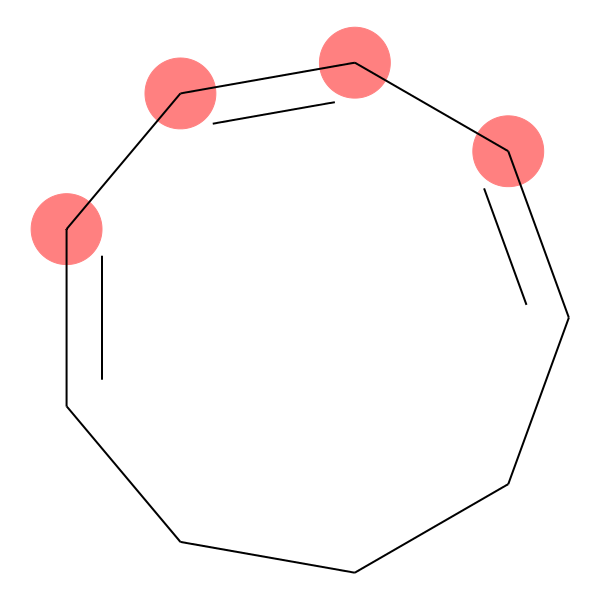

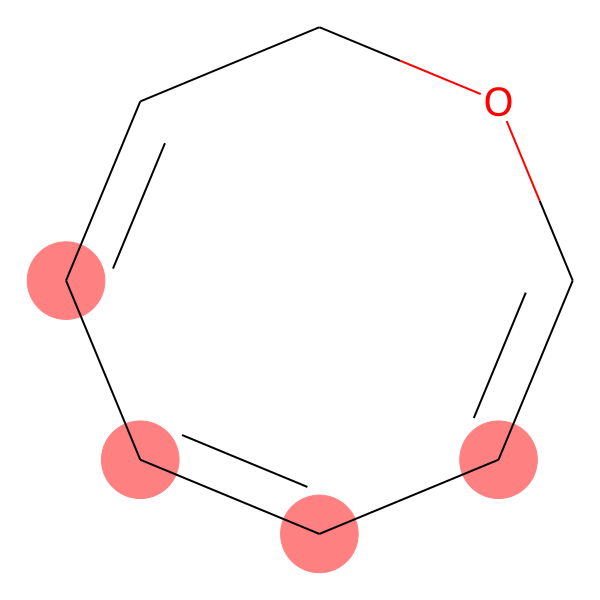

In [9]:
from IPython.display import Image 

for img in image_list:
  display(img)

As we can see above, 5 out of 5 of the model's MLM predictions are chemically valid. Overall, the model seems to understand syntax with a pretty decent degree of certainity.

However, further training on a more specific dataset (say leads for a specific target) may generate a stronger chemical transformer model. Let's now fine-tune our model on a dataset of our choice, ClinTox. You can run ChemBERTa on any MoleculeNet dataset, but for the sake of convinience, we will use ClinTox as it is small and trains quickly.

#### Visualizing the Attention Mechanism in ChemBERTa using BertViz

BertViz is a tool for visualizing attention in the Transformer model, supporting all models from the transformers library (BERT, GPT-2, XLNet, RoBERTa, XLM, CTRL, etc.). It extends the Tensor2Tensor visualization tool by Llion Jones and the transformers library from HuggingFace.

Using this tool, we can easily plug in ChemBERTa from the HuggingFace model hub and visualize the attention patterns produced by one or more attention heads in a given transformer layer. This is known as the attention-head view.

Lets start by obtaining a Javascript object for d3.js and jquery to create interactive visualizations:

In [10]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [11]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))


Now, we create an instance of ChemBERTa, tokenize a set of SMILES strings, and compute the attention for each head in the transformer. There are two available models hosted by DeepChem on HuggingFace's model hub, one being seyonec/ChemBERTa-zinc-base-v1 which is the ChemBERTa model trained via masked lagnuage modelling (MLM) on the ZINC100k dataset, and the other being seyonec/ChemBERTa-zinc250k-v1, which is trained via MLM on the larger ZINC250k dataset.

In the following example, we take two SMILES molecules from the ZINC database with nearly identical chemical structure, the only difference being rooted in chiral specification (hence the additional ‘@‘ symbol). This is a feature of molecules which indicates that there exists tetrahedral centres. ‘@' tells us whether the neighbours of a molecule appear in a counter-clockwise order, whereas ‘@@‘ indicates that the neighbours are ordered in a clockwise direction. The model should ideally refer to similar substructures in each SMILES string with a higher attention weightage.

Lets look at the first SMILES string: CCCCC[C@@H](Br)CC:

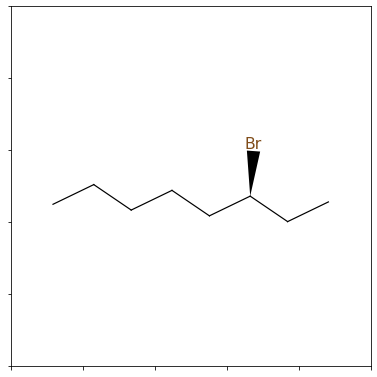

In [12]:
m = Chem.MolFromSmiles('CCCCC[C@@H](Br)CC')
fig = Draw.MolToMPL(m, size=(200, 200))

And the second SMILES string, CCCCC[C@H](Br)CC:

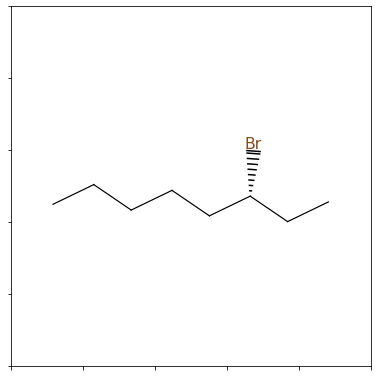

In [13]:
m = Chem.MolFromSmiles('CCCCC[C@H](Br)CC')
fig = Draw.MolToMPL(m, size=(200,200))

The visualization below shows the attention induced by a sample input SMILES. This view visualizes attention as lines connecting the tokens being updated (left) with the tokens being attended to (right), following the design of the figures above. Color intensity reflects the attention weight; weights close to one show as very dark lines, while weights close to zero appear as faint lines or are not visible at all. The user may highlight a particular SMILES character to see the attention from that token only. This visualization is called the attention-head view. It is based on the excellent Tensor2Tensor visualization tool, and are all generated by the Bertviz library.

In [14]:
from transformers import RobertaModel, RobertaTokenizer
from bertviz import head_view

model_version = 'seyonec/PubChem10M_SMILES_BPE_450k'
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

call_html()

head_view(attention, tokens)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<IPython.core.display.Javascript object>


The visualization shows that attention is highest between words that don’t cross a boundary between the two SMILES strings; the model seems to understand that it should relate tokens to other tokens in the same molecule in order to best understand their context.

There are many other fascinating visualizations we can do, such as a neuron-by neuron analysis of attention or a model overview that visualizes all of the heads at once:

#### Fine-tuning ChemBERTa on a Small Mollecular Dataset

Our fine-tuning dataset, ClinTox, consists of qualitative data of drugs approved by the FDA and those that have failed clinical trials for toxicity reasons.

The ClinTox dataset consists of 1478 binary labels for toxicity, using the SMILES representations for identifying molecules. The computational models produced from the dataset could become decision-making tools for government agencies in determining which drugs are of the greatest potential concern to human health. Additionally, these models can act as drug screening tools in the drug discovery pipelines for toxicity.

Let's start by importing the MolNet dataloder from `bert-loves-chemistry`, before importing apex and transformers, the tool which will allow us to import the pre-trained masked-language modelling architecture trained on PubChem.

In [ ]:
%cd /content/bert-loves-chemistry/chemberta

In [ ]:
!pip install transformers==2.11.0 tokenizers==0.10.1 -U
!pip install --upgrade simpletransformers

In [4]:
import os

import numpy as np
import pandas as pd

from typing import List

# import molnet loaders from deepchem
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem

# import MolNet dataloder from bert-loves-chemistry fork
from utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

2021-07-02 21:20:25.401910: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Lets use the MolNet dataloader to generate scaffold splits from the ClinTox dataset.

In [ ]:
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("clintox", tasks_wanted=None)

If you're only running the toxicity prediction portion of this tutorial, make sure you install transformers here. If you've ran all the cells before, you can ignore this install as we've already done pip install transformers before.

In [6]:
train_df

,text,labels
0,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,0
1,O=C(NCC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(N(CCO...,1
2,Clc1cc(Cl)c(OCC#CI)cc1Cl,1
3,N#Cc1cc(NC(=O)C(=O)[O-])c(Cl)c(NC(=O)C(=O)[O-])c1,1
4,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,1
...,...,...
1177,CC(C[NH2+]C1CCCCC1)OC(=O)c1ccccc1,1
1178,CC(C(=O)[O-])c1ccc(C(=O)c2cccs2)cc1,1
1179,CC(c1cc2ccccc2s1)N(O)C(N)=O,1
1180,CC(O)C(CO)NC(=O)C1CSSCC(NC(=O)C([NH3+])Cc2cccc...,1


In [7]:
valid_df

,text,labels
0,CC(C)OC(=O)CCC/C=C\C[C@H]1[C@@H](O)C[C@@H](O)[...,1
1,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,1
2,CC(C)n1c(/C=C/[C@H](O)C[C@H](O)CC(=O)[O-])c(-c...,1
3,CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)[NH+]1CCCC1,1
4,CSCC[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)...,1
...,...,...
143,C[C@H](OC(=O)c1ccccc1)C1=CCC23OCC[NH+](C)CC12C...,1
144,C[C@@H](c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F,1
145,CC(C)C[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H]...,1
146,C[C@H](O)[C@H](O)[C@H]1CNc2[nH]c(N)nc(=O)c2N1,1


In [8]:
test_df

,text,labels
0,C[NH+]1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4C...,1
1,C[C@]1(Cn2ccnn2)[C@H](C(=O)[O-])N2C(=O)C[C@H]2...,1
2,C[NH+]1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1,1
3,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,1
4,OC[C@H]1O[C@@H](n2cnc3c2NC=[NH+]C[C@H]3O)C[C@@...,1
...,...,...
143,O=C1O[C@H]([C@@H](O)CO)C([O-])=C1O,1
144,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H]...,1
145,C#CC[NH2+][C@@H]1CCc2ccccc21,1
146,[H]/[NH+]=C(\N)c1ccc(OCCCCCOc2ccc(/C(N)=[NH+]/...,1


From here, lets set up a logger to record if any issues occur, and notify us if there are any problems with the arguments we've set for the model.

In [9]:
from simpletransformers.classification import ClassificationModel
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Now, using simple-transformer, let's load the pre-trained model from HuggingFace's useful model-hub. We'll set the number of epochs to 3 in the arguments, but you can train for longer. Also make sure that auto_weights is set to True to do automatic weight balancing, as we are dealing with imbalanced toxicity datasets.

In [1]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', args={'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 10, 'auto_weights': True}) # You can set class weights by using the optional weight argument

2021-07-02 21:12:38.603130: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Downloading:   0%|          | 0.00/515 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 and are newly initialized: ['classifier.dense.weigh

Downloading:   0%|          | 0.00/165k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/101k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

In [ ]:
print(model.tokenizer)

In [ ]:
# check if our train and evaluation dataframes are setup properly. There should only be two columns for the SMILES string and its corresponding label.
print("Train Dataset: {}".format(train_df.shape))
print("Eval Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))


Now that we've set everything up, lets get to the fun part: training the model! We use Weights and Biases, which is optional (simply remove wandb_project from the list of args). Its a really useful tool for monitering the model's training results (such as accuracy, learning rate and loss), alongside custom visualizations of attention and gradients.

When you run this cell, Weights and Biases will ask for an account, which you can setup through a Github account, giving you an authorization API key which you can paste into the output of the cell. Again, this is completely optional and it can be removed from the list of arguments.

In [ ]:
!wandb login

Finally, the moment we've been waiting for! Let's train the model on the train scaffold set of ClinTox, and monitor our runs using W&B. We will evaluate the performance of our model each epoch using the validation set.

In [ ]:
# Create directory to store model weights (change path accordingly to where you want!)
!mkdir BPE_PubChem_10M_ClinTox_run

# Train the model
model.train_model(train_df, eval_df=valid_df, output_dir='/content/BPE_PubChem_10M_ClinTox_run', args={'wandb_project': 'project-name'})

Let's install scikit-learn now, to evaluate the model we've trained.

In [ ]:
import sklearn

# accuracy
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.accuracy_score)

# ROC-PRC
result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=sklearn.metrics.average_precision_score)


The model performs pretty well, averaging above 97% ROC-PRC after training on only ~1400 data samples and 150 positive leads in a couple of minutes! We can clearly see the predictive power of transfer learning, and approaches like these are becoming increasing popular in the pharmaceutical industry where larger datasets are scarce. By training on more epochs and tasks, we can probably boost the accuracy as well!

Lets evaluate the model on one last string from ClinTox's test set for toxicity. The model should predict 1, meaning the drug failed clinical trials for toxicity reasons and wasn't approved by the FDA.

In [ ]:
# Lets input a molecule with a toxicity value of 1
predictions, raw_outputs = model.predict(['C1=C(C(=O)NC(=O)N1)F'])

In [ ]:
print(predictions)
print(raw_outputs)

The model predicts the sample correctly! Some future tasks may include using the same model on multiple tasks (Tox21 provides multiple tasks relating to different biochemical pathways for toxicity, as an example), through multi-task classification, as well as training on a larger dataset such as HIV, one of the other harder tasks in molecular machine learning. This will be expanded on in future work! In the next tutorial, we'll be training a similar variant of ChemBERTa, that utilizes a different tokenizer, the SmilesTokenizer which is built-in to DeepChem! Let see if using a tokenizer which splits SMILES sequences into syntatically relevant chemical tokens performs differently, especially on attention visualizaiton tasks!